# Packages

In [1]:
import ipywidgets as widgets
from IPython.display import display as ipydisplay, clear_output

import numpy as np
import IPython.display as display


import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.axes import Axes

import time

import asyncio
import zmq
import threading
import contextlib
import io

import typing as tp

# Dummy measurement

Just some dummy measurements coded in a form of quantrol package. They are used to test different layouts of the widget. The "Ramsey" one has a line plot along with a map, and the 'RO' has a signle map.  

In [2]:
class Ramsey:
    def __init__(self):
        self.w = 2*np.pi/2
        self.k = 0.2
        self.t_max = 10
        self.n_points = 100

        self.nx = 50
        self.ny = 100
        
        self.n_iterations = 1_000
        self.iter = 0
        self.flag = True
        
        self.x = np.linspace(0, self.t_max, self.n_points)
        self.ps = (1-np.exp(-self.k*self.x)*np.sin(self.w*self.x))/2

        self.xs = np.linspace(0, 5, self.nx)
        self.ys = np.linspace(0, 10, self.ny)
        
        self.y = np.zeros(self.n_points)
        
        x, y = np.meshgrid(self.xs, self.ys)
        k_x = 1.5
        k_y = 4
        self.ps_z = np.exp(-((x-2.5)/k_x)**2 - ((y-5)/k_y)**2)
        self.z = np.zeros((self.ny, self.nx))
        
        self.rng = np.random.default_rng()

    def math_func(self):
        return np.array(self.rng.uniform(0,1, size = self.n_points) > self.ps, dtype = float)

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.y = self.y + self.math_func()
            self.z = self.z + self.map_func()
            yield self.y/self.iter, self.z/self.iter

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        y, z = next(self.data)
        signal = {
            'line' : y,
            'map' : z
        }
        fit = {
            'line' : self.ps,
        }

        return (signal, fit)
    
    def plot(self, signal, fit, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 2, figsize = (10,5))
            self.hdisplay = display(self.fig, display_id = True)
        else:
            for ax in self.axs:
                ax.clear()
        
        y = signal['line']
        z = signal['map']

        y_fit = fit['line']
        
        
        self.axs[0].scatter(self.x, y)
        self.axs[0].plot(self.x, y_fit)
        
        self.axs[1].pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        self.hdisplay.update(obj = self.fig)
        if save:
            print('Saved')
        else:
            pass

class RO:
    def __init__(self):
        self.nx = 51
        self.ny = 51
        
        self.n_iterations = 1_000_000
        self.iter = 0

        self.xs = np.linspace(-10, 10, self.nx)
        self.ys = np.linspace(-10, 10, self.ny)
        
        x, y = np.meshgrid(self.xs, self.ys)

        self.flag = True
        
        k_x = 1.5
        k_y = 1.5

        x_0, y_0 = 3, 3
        
        self.ps_z = np.exp(-((x-x_0)/k_x)**2 - ((y-y_0)/k_y)**2) + np.exp(-((x+x_0)/k_x)**2 - ((y+y_0)/k_y)**2)
        self.ps_z = self.ps_z / np.max(self.ps_z)
        self.z = np.zeros((self.ny, self.nx))
        self.rng = np.random.default_rng()

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.z = self.z + self.map_func()
            z = self.z/self.iter
            
            yield z

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        z = next(self.data)
        signal = {
            'map' : z,
        }
        return (signal,)
    
    def plot(self, signal, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 1, figsize = (10,5))
        else:
            self.axs.clear()
    
        z = signal['map']
        
        self.axs.pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        if save:
            print('Saved')
        else:
            pass

In [4]:
class Ramsey:
    def __init__(self):
        self.w = 2*np.pi/2
        self.k = 0.2
        self.t_max = 10
        self.n_points = 100

        self.nx = 50
        self.ny = 100
        
        self.n_iterations = 1_000
        self.iter = 0
        self.flag = True
        
        self.x = np.linspace(0, self.t_max, self.n_points)
        self.ps = (1-np.exp(-self.k*self.x)*np.sin(self.w*self.x))/2

        self.xs = np.linspace(0, 5, self.nx)
        self.ys = np.linspace(0, 10, self.ny)
        
        self.y = np.zeros(self.n_points)
        
        x, y = np.meshgrid(self.xs, self.ys)
        k_x = 1.5
        k_y = 4
        self.ps_z = np.exp(-((x-2.5)/k_x)**2 - ((y-5)/k_y)**2)
        self.z = np.zeros((self.ny, self.nx))
        
        self.rng = np.random.default_rng()

    def math_func(self):
        return np.array(self.rng.uniform(0,1, size = self.n_points) < self.ps, dtype = float)

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.y = self.y + self.math_func()
            self.z = self.z + self.map_func()
            yield self.y/self.iter, self.z/self.iter

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        y, z = next(self.data)
        signal = {
            'line' : y,
            'map' : z
        }
        fit = {
            'line' : self.ps,
        }

        return (signal, fit)
    
    def plot(self, signal, fit, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 2, figsize = (10,5))
        else:
            for ax in self.axs:
                ax.clear()
        
        y = signal['line']
        z = signal['map']

        y_fit = fit['line']
        
        
        self.axs[0].scatter(self.x, y)
        self.axs[0].plot(self.x, y_fit)
        
        self.axs[1].pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        
        if save:
            print('Saved')
        else:
            pass
    def getData(self):
        data = self.data

        data_pack = {
            "iter" : self.iter,
            "name" : "Ramsey",
            "n_iterations" : self.n_iterations,
            }

        data_pack["layout"] = {
                "line" : {
                    'types' : ['Scatter', 'Line'],
                    'lines' : ['signal', 'fit'],
                    'x_label' : "t [ms]",
                    'y_label' : r'$p_e$',
                    'loc' : [0, 0, 1, 1]
                },

                "map" : {
                    'type' : 'Map',
                    'loc' : [0, 1, 1, 1]
                },
            }

        signal, fit = self.analysis(data)


        data_pack["data"] = {
            'line_signal' : {
                'x' : self.x,
                'y' : signal['line'],
            },
            'line_fit': {
                'x' : self.x,
                'y' : fit['line'],
            },
            'map' : {
                'x' : self.xs,
                'y' : self.ys,
                'z' : signal['map']
            },
        }
        return data_pack


class RO:
    def __init__(self):
        self.nx = 51
        self.ny = 51
        
        self.n_iterations = 1_000
        self.iter = 0

        self.xs = np.linspace(-10, 10, self.nx)
        self.ys = np.linspace(-10, 10, self.ny)
        
        x, y = np.meshgrid(self.xs, self.ys)

        self.flag = True
        
        k_x = 1.5
        k_y = 1.5

        x_0, y_0 = 3, 3
        
        self.ps_z = np.exp(-((x-x_0)/k_x)**2 - ((y-y_0)/k_y)**2) + np.exp(-((x+x_0)/k_x)**2 - ((y+y_0)/k_y)**2)
        self.ps_z = self.ps_z / np.max(self.ps_z)
        self.z = np.zeros((self.ny, self.nx))
        self.rng = np.random.default_rng()

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.z = self.z + self.map_func()
            z = self.z/self.iter
            
            yield z

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        z = next(self.data)
        signal = {
            'map' : z,
        }
        return (signal,)
    
    def plot(self, signal, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 1, figsize = (10,5))
        else:
            self.axs.clear()
    
        z = signal['map']
        
        self.axs.pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        if save:
            print('Saved')
        else:
            pass
    

    def getData(self):
        data = self.data

        data_pack = {
            "iter" : self.iter,
            "name" : "RO",
            "n_iterations" : self.n_iterations,
            }

        data_pack["layout"] = {
                "IQ" : {
                    'type' : 'Map',
                    'x_label' : "I [V]",
                    'y_label' : "Q [V]",
                    'loc' : [0, 0, 1, 1]
                },
            }

        signal, = self.analysis(data)
        


        data_pack["data"] = {
            'IQ' : {
                'x' : self.xs,
                'y' : self.ys,
                'z' : signal['map'],
            },
        }
        return data_pack

# First approach: Matplotlib widget

Here, we create a ipywidget output which contains start and stop buttons, and the region to plot the results.

In [23]:
class Test:
    def __del__(self):
        print('I am deleted')

In [24]:
test = Test()

In [25]:
test = 1

I am deleted


In [3]:
class LivePlot:
    def __init__(self, experiment, result_handles, name = None, refresh_time = 1):
        self.experiment = experiment
        self.is_running = False
        self.data = result_handles

        self.start_button = widgets.Button(description="Start", button_style='success')
        self.stop_button = widgets.Button(description="Stop", button_style='danger', disabled=True)
        self.output_area = widgets.Output()

        self.start_button.on_click(self.start)
        self.stop_button.on_click(self.stop)

        self.buttons = widgets.HBox([self.start_button, self.stop_button])
        self.layout = widgets.VBox([self.buttons, self.output_area])

        self.refresh_time = refresh_time

        clear_output(wait=True)

        ipydisplay(self.layout)


        with self.output_area:
            #self.experiment.plot(*self.experiment.analysis(self.data), save = False)
            self.experiment.plot(*self.experiment.analysis(self.data), save = False)


    def start(self, b):
        if not self.is_running:
            self.is_running = True
            self.stop_button.disabled = False
            self.start_button.disabled = True
            #self.signal, self.fit = self.experiment.analysis(self.data)
            self.signal = self.experiment.analysis(self.data)
            self.task = asyncio.create_task(self.run_plotting())
            self.data_task = asyncio.create_task(self.get_data())

    async def run_plotting(self):
        while self.is_running and self.experiment.iter < self.experiment.n_iterations:
            with self.output_area:
                #self.experiment.plot(self.signal, self.fit, live = True, save = False)
                self.experiment.plot(*self.signal, live = True, save = False)
            await asyncio.sleep(self.refresh_time)  # Update interval
        self.stop(None)  # Auto-stop when done

    async def get_data(self):
        while self.is_running and self.experiment.iter < self.experiment.n_iterations:
            #self.signal, self.fit = self.experiment.analysis(self.data)
            self.signal = self.experiment.analysis(self.data)
            await asyncio.sleep(0.9*self.refresh_time)  # Update interval
        self.stop(None)  # Auto-stop when done

    def stop(self, b):
        if self.is_running:
            self.is_running = False
            self.stop_button.disabled = True
            self.start_button.disabled = False
            if self.task and not self.task.done():
                self.task.cancel()
                self.data_task.cancel()
            #self.experiment.plot(*self.experiment.analysis(self.data), live = True, save = True)
            self.experiment.plot(*self.experiment.analysis(self.data), live = True, save = True)



In [11]:
%matplotlib widget

In [2]:
from Utils_plot import LivePlot

In [17]:
meas = Ramsey()
data = meas.execute_meas()

In [9]:
meas = RO()
data = meas.execute_meas()

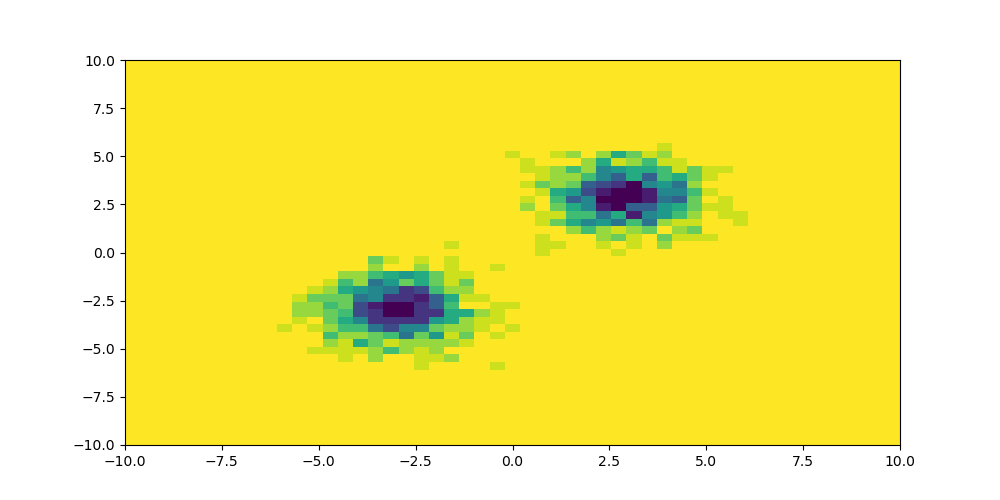

In [12]:
live = LivePlot(meas, data)

In [15]:
%matplotlib inline

# DeepMind guy solution

In [36]:
if tp.TYPE_CHECKING:
  PlotBase = Axes
else:
  PlotBase = object


class Plot(PlotBase):
  def __init__(self, *args, **kwargs):
    self.fig = plt.figure(*args, **kwargs)
    self.ax = self.fig.gca()
    
      
    self.disp = display.display(self.fig, display_id=str(id(self)))

  if not tp.TYPE_CHECKING:

    def __getattr__(self, name):
      return getattr(self.ax, name)

  def __enter__(self):
    self.ax.cla()#clear()
      

  def __exit__(self, *args):
    self.fig.canvas.draw()
    self.disp.update(self.fig)

  def close(self):
    plt.close(self.fig)

        
class LivePlot:
    def __init__(self, experiment, result_handles, name = None, refresh_time = 1):
        self.experiment = experiment
        self.is_running = False
        self.data = result_handles

        self.refresh_time = refresh_time
        self.start()


    def start(self):
        if not self.is_running:
            self.is_running = True
            self.signal = self.experiment.analysis(self.data)
            
            self.experiment.plot(*self.signal, live = False, save = False)
            self.task = asyncio.create_task(self.run_plotting())
            self.data_task = asyncio.create_task(self.get_data())

    async def run_plotting(self):
        while self.is_running and self.experiment.iter < self.experiment.n_iterations:
            self.experiment.plot(*self.signal, live = True, save = False)
            await asyncio.sleep(self.refresh_time)  # Update interval
        self.stop(None)  # Auto-stop when done

    async def get_data(self):
        while self.is_running and self.experiment.iter < self.experiment.n_iterations:
            #self.signal, self.fit = self.experiment.analysis(self.data)
            self.signal = self.experiment.analysis(self.data)
            await asyncio.sleep(0.9*self.refresh_time)  # Update interval
        self.stop(None)  # Auto-stop when done

    def stop(self):
        if self.is_running:
            self.is_running = False
            if self.task and not self.task.done():
                self.task.cancel()
                self.data_task.cancel()
            #self.experiment.plot(*self.experiment.analysis(self.data), live = True, save = True)
            self.experiment.plot(*self.experiment.analysis(self.data), live = True, save = True)
            plt.ioff()
            self.experiment.ax_plot.close()


In [37]:
class RO:
    def __init__(self):
        self.nx = 51
        self.ny = 51
        
        self.n_iterations = 1_000_000
        self.iter = 0

        self.xs = np.linspace(-10, 10, self.nx)
        self.ys = np.linspace(-10, 10, self.ny)
        
        x, y = np.meshgrid(self.xs, self.ys)

        self.flag = True
        
        k_x = 1.5
        k_y = 1.5

        x_0, y_0 = 3, 3
        
        self.ps_z = np.exp(-((x-x_0)/k_x)**2 - ((y-y_0)/k_y)**2) + np.exp(-((x+x_0)/k_x)**2 - ((y+y_0)/k_y)**2)
        self.ps_z = self.ps_z / np.max(self.ps_z)
        self.z = np.zeros((self.ny, self.nx))
        self.rng = np.random.default_rng()

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.z = self.z + self.map_func()
            z = self.z/self.iter
            
            yield z

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        z = next(self.data)
        signal = {
            'map' : z,
        }
        return (signal,)
    
    def plot(self, signal, live = False, save = False):
        if not live:
            self.ax_plot = Plot(figsize = (10,5))
        # else:
        #     self.axs.clear()
    
        z = signal['map']
        with self.ax_plot:
            self.ax_plot.pcolorfast(self.xs, self.ys, z)

        if save:
            print('Saved')
        else:
            pass

In [38]:
meas = RO()
data = meas.execute_meas()

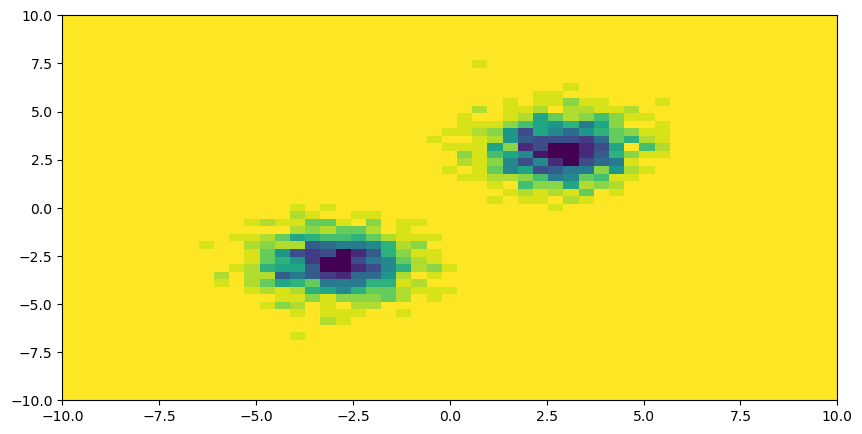

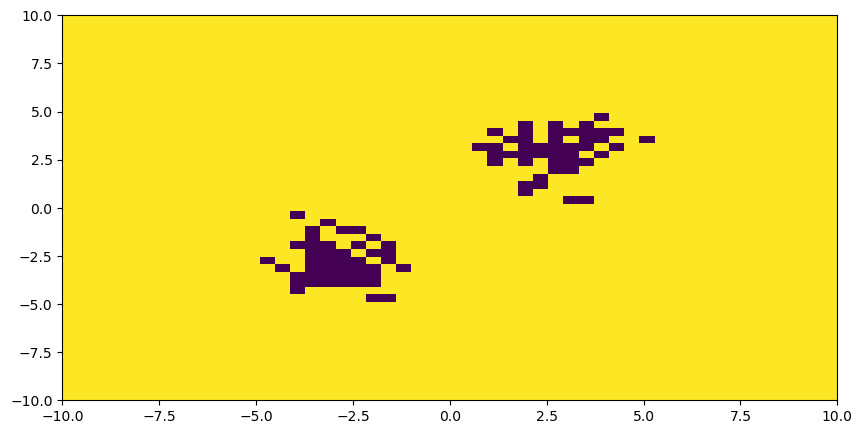

In [39]:
%matplotlib inline
live = LivePlot(meas, data)

In [40]:
live.stop()

Saved


# pyqtgraph approach

In [2]:
class Ramsey:
    def __init__(self):
        self.w = 2*np.pi/2
        self.k = 0.2
        self.t_max = 10
        self.n_points = 100

        self.nx = 50
        self.ny = 100
        
        self.n_iterations = 1_000
        self.iter = 0
        self.flag = True
        
        self.x = np.linspace(0, self.t_max, self.n_points)
        self.ps = (1-np.exp(-self.k*self.x)*np.sin(self.w*self.x))/2

        self.xs = np.linspace(0, 5, self.nx)
        self.ys = np.linspace(0, 10, self.ny)
        
        self.y = np.zeros(self.n_points)
        
        x, y = np.meshgrid(self.xs, self.ys)
        k_x = 1.5
        k_y = 4
        self.ps_z = np.exp(-((x-2.5)/k_x)**2 - ((y-5)/k_y)**2)
        self.z = np.zeros((self.ny, self.nx))
        
        self.rng = np.random.default_rng()

    def math_func(self):
        return np.array(self.rng.uniform(0,1, size = self.n_points) < self.ps, dtype = float)

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.y = self.y + self.math_func()
            self.z = self.z + self.map_func()
            yield self.y/self.iter, self.z/self.iter

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        y, z = next(self.data)
        signal = {
            'line' : y,
            'map' : z
        }
        fit = {
            'line' : self.ps,
        }

        return (signal, fit)
    
    def plot(self, signal, fit, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 2, figsize = (10,5))
            self.hdisplay = display(self.fig, display_id = True)
        else:
            for ax in self.axs:
                ax.clear()
        
        y = signal['line']
        z = signal['map']

        y_fit = fit['line']
        
        
        self.axs[0].scatter(self.x, y)
        self.axs[0].plot(self.x, y_fit)
        
        self.axs[1].pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        self.hdisplay.update(obj = self.fig)
        if save:
            print('Saved')
        else:
            pass
    def getData(self):
        data = self.data

        data_pack = {
            "iter" : self.iter,
            "name" : "Ramsey",
            "n_iterations" : self.n_iterations,
            }

        data_pack["layout"] = {
                "line" : {
                    'types' : ['Scatter', 'Line'],
                    'lines' : ['signal', 'fit'],
                    'x_label' : "t [ms]",
                    'y_label' : r'$p_e$',
                    'loc' : [0, 0, 1, 1]
                },

                "map" : {
                    'type' : 'Map',
                    'loc' : [0, 1, 1, 1]
                },
            }

        signal, fit = self.analysis(data)


        data_pack["data"] = {
            'line_signal' : {
                'x' : self.x,
                'y' : signal['line'],
            },
            'line_fit': {
                'x' : self.x,
                'y' : fit['line'],
            },
            'map' : {
                'x' : self.xs,
                'y' : self.ys,
                'z' : signal['map']
            },
        }
        return data_pack


class RO:
    def __init__(self):
        self.nx = 51
        self.ny = 51
        
        self.n_iterations = 1_000_000
        self.iter = 0

        self.xs = np.linspace(-10, 10, self.nx)
        self.ys = np.linspace(-10, 10, self.ny)
        
        x, y = np.meshgrid(self.xs, self.ys)

        self.flag = True
        
        k_x = 1.5
        k_y = 1.5

        x_0, y_0 = 3, 3
        
        self.ps_z = np.exp(-((x-x_0)/k_x)**2 - ((y-y_0)/k_y)**2) + np.exp(-((x+x_0)/k_x)**2 - ((y+y_0)/k_y)**2)
        self.ps_z = self.ps_z / np.max(self.ps_z)
        self.z = np.zeros((self.ny, self.nx))
        self.rng = np.random.default_rng()

    def map_func(self):
        return np.array(np.reshape(self.rng.uniform(0,1, size = (self.ny, self.nx)), (self.ny, self.nx)) > self.ps_z, dtype = float)
        
    def get_data(self):
        while self.iter < (self.n_iterations - 1) and self.flag:
            self.iter += 1
            self.z = self.z + self.map_func()
            z = self.z/self.iter
            
            yield z

    def execute_meas(self):
        self.data = self.get_data()
        return self.data
        
    def analysis(self, data):
        z = next(self.data)
        signal = {
            'map' : z,
        }
        return (signal,)
    
    def plot(self, signal, live = False, save = False):
        if not live:
            self.fig, self.axs = plt.subplots(1, 1, figsize = (10,5))
        else:
            self.axs.clear()
    
        z = signal['map']
        
        self.axs.pcolorfast(self.xs, self.ys, z)

        self.fig.canvas.draw()
        if save:
            print('Saved')
        else:
            pass
    

    def getData(self):
        data = self.data

        data_pack = {
            "iter" : self.iter,
            "name" : "RO",
            "n_iterations" : self.n_iterations,
            }

        data_pack["layout"] = {
                "IQ" : {
                    'type' : 'Map',
                    'x_label' : "I [V]",
                    'y_label' : "Q [V]",
                    'loc' : [0, 0, 1, 1]
                },
            }

        signal, = self.analysis(data)
        


        data_pack["data"] = {
            'IQ' : {
                'x' : self.xs,
                'y' : self.ys,
                'z' : signal['map'],
            },
        }
        return data_pack


In [3]:
DATA_PORT = 5555
CONTROL_PORT = 5556

class LivePlotting:
    def __init__(self):
        self.context = zmq.Context()

        self.socket = self.context.socket(zmq.PUB)
        self.socket.bind(f"tcp://*:{DATA_PORT}")
        self.socket.setsockopt(zmq.SNDHWM, 1)
        self._stop_event = threading.Event()
        self._thread = None

        self.control_context = zmq.Context()
        self.control_socket = self.control_context.socket(zmq.REP)
        self.control_socket.bind(f"tcp://*:{CONTROL_PORT}")
        self._running = True

        self._save = False

    def _fetch_and_send_data(self, meas):
        while not self._stop_event.is_set():
            with contextlib.redirect_stdout(io.StringIO()):
                data = meas.getData()
            self.socket.send_pyobj(data)
            if self.meas.iter == meas.n_iterations-1:
                time.sleep(1)
                with contextlib.redirect_stdout(io.StringIO()):
                    data = meas.getData()
                self.socket.send_pyobj(data)
                self._stop_event.set()
                self._thread.join()

            time.sleep(1)  # Adjust the sleep time as needed

    def handle_control(self):
        poller = zmq.Poller()
        poller.register(self.control_socket, zmq.POLLIN)

        while self.running:
            socks = dict(poller.poll(100))  # Poll sockets with a 100-ms timeout
            if self.control_socket in socks and socks[self.control_socket] == zmq.POLLIN:
                try:
                    message = self.control_socket.recv_string(flags=zmq.NOBLOCK)
                    if message == "SAVE":
                        self.control_socket.send_string("OK")
                        save_thread = threading.Thread(target=self.meas.plot, args= self.signal,
                                                        kwargs= {'show_fig' : False,'save' : True})
                        save_thread.start()
                except zmq.ZMQError as e:
                    if e.errno == zmq.ETERM:
                        break

    def start_control_thread(self):
        control_thread = threading.Thread(target=self.handle_control)
        control_thread.start()

    def start(self, meas, refresh_rate = 1):
        '''
        Receives as an argument a measurement and a refresh rate in seconds.
        '''
        self.stop()

        self.meas = meas
        self.running = True

        self._stop_event.clear()
        self._thread = threading.Thread(target=self._fetch_and_send_data, args=(meas,))
        self._thread.start()

        self.start_control_thread()

    def stop(self):
        if self._thread is not None and self._thread.is_alive():
            self._stop_event.set()
            self._thread.join()
            self.running = False


DATA_PORT = 5555
CONTROL_PORT = 5556

class LivePlotting:
    def __init__(self):
        self.context = zmq.Context()

        self.socket = self.context.socket(zmq.PUB)
        self.socket.bind(f"tcp://*:{DATA_PORT}")
        self.socket.setsockopt(zmq.SNDHWM, 1)

        self.control_context = zmq.Context()
        self.control_socket = self.control_context.socket(zmq.REP)
        self.control_socket.bind(f"tcp://*:{CONTROL_PORT}")
        
        self._running = False
        self._save = False

        self._stop_event = threading.Event()
        self._thread = None
        self._lock = threading.RLock()  # Recursive lock to prevent deadlock within the same thread

    def _fetch_and_send_data(self, meas):
        while not self._stop_event.is_set():
            with self._lock:
                data = meas.getData()
                iter = self.meas.iter
                
            self.socket.send_pyobj(data)
            
                
            if iter == meas.n_iterations-1:
                self._stop_event.set()
                time.sleep(1)
                
                with self._lock:
                    data = meas.getData()
                self.socket.send_pyobj(data)
                    #self._stop_event.set()
                    #self._thread.join(0)

            time.sleep(1)  # Adjust the sleep time as needed

    def handle_control(self):
        poller = zmq.Poller()
        poller.register(self.control_socket, zmq.POLLIN)

        while not self._stop_event.is_set():
            socks = dict(poller.poll(100))  # Poll sockets with a 100-ms timeout
            if self.control_socket in socks and socks[self.control_socket] == zmq.POLLIN:
                try:
                    message = self.control_socket.recv_string(flags=zmq.NOBLOCK)
                    if message == "SAVE":
                        self.control_socket.send_string("OK")
                        save_thread = threading.Thread(target=self.meas.plot, args= self.signal,
                                                        kwargs= {'show_fig' : False,'save' : True})
                        save_thread.start()
                except zmq.ZMQError as e:
                    if e.errno == zmq.ETERM:
                        break

    def start_control_thread(self):
        self._control_thread = threading.Thread(target=self.handle_control)
        self._control_thread.start()

    def start(self, meas, refresh_rate = 1):
        '''
        Receives as an argument a measurement and a refresh rate in seconds.
        '''
        self.refresh_rate = refresh_rate
        self.stop()

        self.meas = meas
        self.running = True

        self._stop_event.clear()
        self._thread = threading.Thread(target=self._fetch_and_send_data, args=(meas,))
        self._thread.start()

        self.start_control_thread()

    def stop(self):
        if self._thread is not None and self._thread.is_alive():
            self._stop_event.set()
            self._thread.join()
            self._control_thread.join()
            self.running = False

In [5]:
livePlotter = LivePlotting()

ZMQError: Address in use (addr='tcp://*:5555')

In [11]:
meas = RO()
data = meas.execute_meas()

In [12]:
livePlotter.start(meas)

In [8]:
meas = Ramsey()
data = meas.execute_meas()

In [9]:
livePlotter.start(meas)

In [10]:
1

1